In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [73]:
### Import Libraries 
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
import seaborn as sns
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Input, SimpleRNN, GRU
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\komyshev.da\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
### Reading csv data files using pandas dataframe 

train = pd.read_csv("./train.csv", encoding = "ISO-8859-1")
test = pd.read_csv("./test.csv", encoding = "ISO-8859-1")

In [8]:
### Checking nulls in both the datasets

print("Nulls in training dataset",train.isnull().sum())
print("\nNulls in test dataset",test.isnull().sum())

### There are no missing values in both the datasets

Nulls in training dataset id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Nulls in test dataset id              0
comment_text    0
dtype: int64


In [9]:
### Before cleaning the dataset I would like to perform EDA(Exploratory data analysis) by performing data visualization to understand
### the distribution of different classes. I will be performing EDA on training dataset

categorywise_data = train.drop(['id', 'comment_text'], axis=1)     ### Removed unnecessary columns - id and comment_text
counts_category = []                                               ### A list that contains tuple which consists of class label and number of comments for that particular class 
categories = list(categorywise_data.columns.values)
for i in categories:
    counts_category.append((i, categorywise_data[i].sum()))
    
dataframe = pd.DataFrame(counts_category, columns=['Labels', 'number_of_comments'])   ### Dataframe made up of category and total number of comments

In [10]:
counts_category

[('toxic', 15294),
 ('severe_toxic', 1595),
 ('obscene', 8449),
 ('threat', 478),
 ('insult', 7877),
 ('identity_hate', 1405)]

Text(0.5, 0, 'Labels')

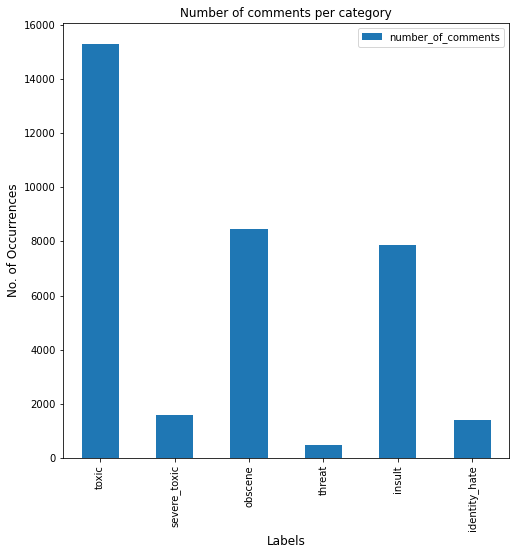

In [11]:
### Visualization 1

### Bar graph of total number of comments per label 
### This visualization is helpful in identifying the total number of comments per label
dataframe.plot(x='Labels', y='number_of_comments', kind='bar',figsize=(8,8))
plt.title("Number of comments per category")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Labels', fontsize=12)

### From the below graph we can observe that most of the comments having toxic label. 
### Threat label is having lowest no. of comments

,0,Total no. of sentences,Total No. of labels in a sentence
0,143346,143346,0
1,6360,6360,1
3,4209,4209,3
2,3480,3480,2
4,1760,1760,4
5,385,385,5
6,31,31,6


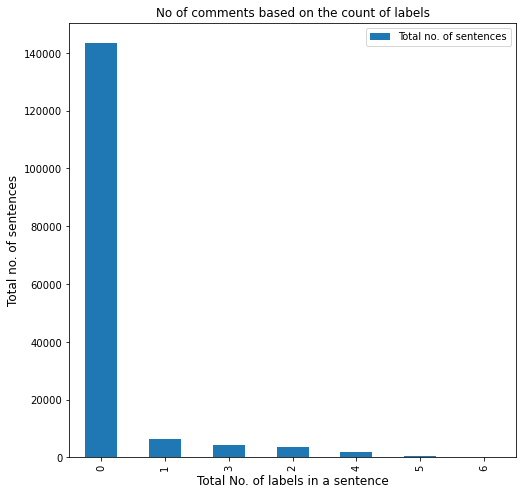

In [13]:
### Visualization 2

### Bar graph of Total No. of labels in a sentence against Total no. of sentences
### This visualization is helpful in identifying whether a sentence belongs to only one category or many categories

dataframe = pd.DataFrame(pd.DataFrame(train[train.columns[2:]].sum(axis=1)).reset_index()[0].value_counts())
dataframe["Total no. of sentences"]=dataframe[0]
dataframe["Total No. of labels in a sentence"]=dataframe.index
dataframe.plot(x="Total No. of labels in a sentence", y="Total no. of sentences", kind='bar',figsize=(8,8))
plt.title("No of comments based on the count of labels")
plt.ylabel('Total no. of sentences', fontsize=12)
plt.xlabel('Total No. of labels in a sentence', fontsize=12)
dataframe

### From the below graph we can see that 1,43,346 out of 1,59,571 sentences does not have any labels(class 0).
### we can observe that a single sentence can have multiple labels. It can be a toxic sentence or it can be a toxic as well as obscene senetence.

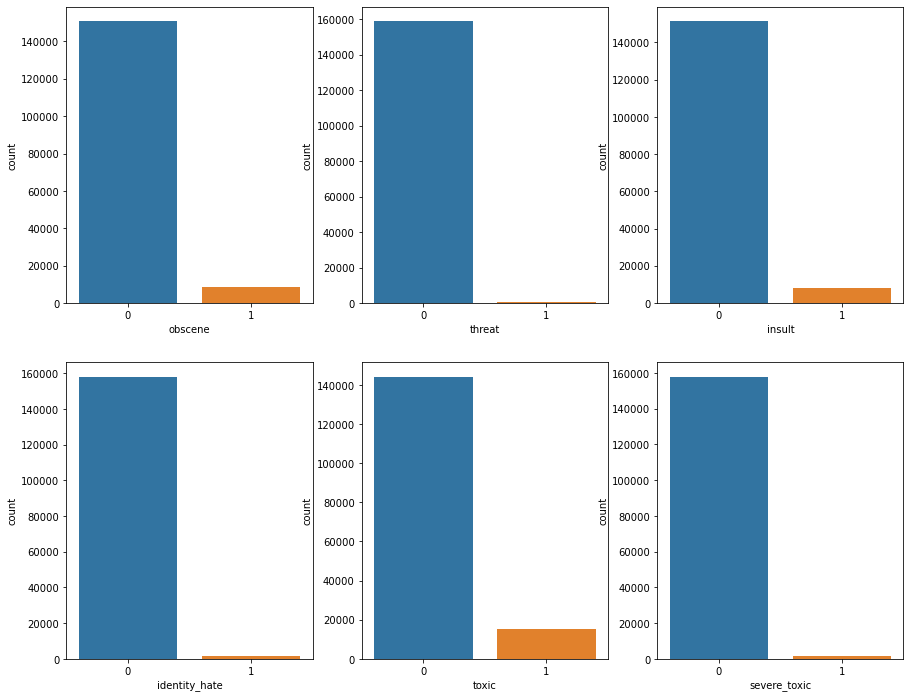

In [14]:
### Visualization 3

### Graph of individual class against the total no. of labelled and unlabelled sentences for the same class

fig, plots = plt.subplots(2,3,figsize=(15,12))
plot1, plot2, plot3, plot4, plot5, plot6 = plots.flatten()
sns.countplot(train['obscene'], ax = plot1)
sns.countplot(train['threat'], ax = plot2)
sns.countplot(train['insult'], ax = plot3)
sns.countplot(train['identity_hate'], ax = plot4)
sns.countplot(train['toxic'], ax = plot5)
sns.countplot(train['severe_toxic'], ax = plot6)

### From this graph it can be concluded that every class(category) is having higher no. of unlabelled sentences(0) as compared
### to labelled sentences(1)

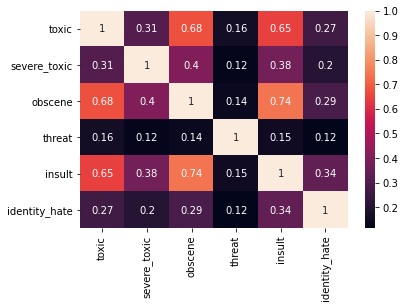

In [15]:
### Visualization 4

### Correlation between different variables
### Correlation helps us finding relationship/dependency between different variables. 

target_data = train.drop(['id', 'comment_text'], axis=1)
corrMatrix = target_data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

### Correlation coefficient ranges from -1 to 1. Values always range between -1 imply strong negative relationship
### between variables and +1 imply a strong positive relationship between variables. 
### Values at or close to zero imply weak or no linear relationship. 
### From the correlation matrix(graph), it can be concluded that some labels are highely correlated. Those varibles are mentioned below 
### (Correlation coefficient for insult-obscene is 0.74, Correlation coefficient for toxic-obscene is 0.68 and Correlation coefficient for toxic-insult is 0.65).

In [16]:
### From visualization we can conclude following things
### 1) A single sentence can have multiple labels (categories)
### 2) Some labels are highely correlated to each other
### 3) This is multi label classification problem 

In [17]:
### Data cleaning/Preparation 

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)      ### conversion of contraction words to expanded words
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)                                                 ### removing non-word characters
    text = re.sub('[^A-Za-z\' ]+', '',text)                                        ### removing all non-alphanumeric values(Except single quotes)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    text = ' '.join([word for word in text.split() if word not in (stop_words)])    ### Stopwords removal
    return text

train["comment_text"] = train["comment_text"].apply(clean_text)
test["comment_text"] = test["comment_text"].apply(clean_text)


In [18]:
### Splitting up the labels and data
### Training dataset is splitted into 2 parts. 1st part includes the training data(train_data) and 2nd part includes labels(train_label) 
### associated with the training data
### Test dataset is having only 1 part i.e. test data which is used to predict the labels. 

train_data = train["comment_text"]
test_data = test["comment_text"]
train_label=train[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]


In [20]:
### Creating corpus of words and coverting it into integer and then susbstituing it in sentences - prepare tokenizer
tokenizer = Tokenizer(num_words = 40000) #40000 words are used here
tokenizer.fit_on_texts(train_data)

#convert each text into array of integers with help of tokenizer.
train_final = tokenizer.texts_to_sequences(train_data)
test_final = tokenizer.texts_to_sequences(test_data)

In [21]:
### Padding - Every sentence is unequal in length. We need to have all the sentence equal in lengths
### If length of sentence is less than 150 then padding will increase sentence length to 150 by adding zeros, if its greater
### than 150 then it will reduce the length of sentence to 150 by trimming the words

train_padded =pad_sequences(train_final, maxlen=150)
test_padded =pad_sequences(test_final, maxlen=150)
print("Shape of training data",train_padded.shape)
print("Shape of testing data",test_padded.shape)


Shape of training data (159571, 150)
Shape of testing data (153164, 150)


In [86]:
x_train, x_val, y_train, y_val = train_test_split(train_padded, train_label, shuffle = True, random_state = 123)

## LSTM

In [85]:
### Building a model
### I have built a sequential model using LSTM. Initial layer contains a word embedding layer having 128 hidden units. 
### Input to the LSTM model is given in the shape of an array of (159571, 150). There are 6 main classes and every class is having 2 sub classes.
### For every Input observation, there are 6 labels. 
### I have used 2 LSTM layer with 64 hidden units. 1 Dense layer which is an output layer. Dropout probability is set to 0.2 for
### 2 lSTM layers which will dropout the 20 percent of neuron automatically while training.Dropout resolves the problem of overfitting. 
### Output layer contains 6 hidden units. I have used sigmoid activation function in the output layer. The reason behind using
### sigmoid activation function in the output layer is because we have multi label classification problem.
### Every class(label) is having 2 more classes i.e.0 and 1 to predict. 

model_LSTM = Sequential()
model_LSTM.add(Embedding(40000, 128))
model_LSTM.add(LSTM(units = 64, dropout = 0.2,return_sequences=True))
model_LSTM.add(LSTM(units = 64, dropout = 0.2))
model_LSTM.add(Dense(units = 6, activation = 'sigmoid'))
model_LSTM.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 128)         5120000   
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
Total params: 5,202,822
Trainable params: 5,202,822
Non-trainable params: 0
_________________________________________________________________


In [89]:
model_LSTM.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["AUC"])
model_LSTM.fit(x_train, y_train, batch_size = 32, epochs = 1, validation_data = (x_val, y_val))

3740/3740 [==============================] - 620s 166ms/step - loss: 0.0723 - auc: 0.9559 - val_loss: 0.0518 - val_auc: 0.9717


In [106]:
### predicted probabilities of each id in the test set, for all the target columns
predict_LSTM = model_LSTM.predict(test_padded)

target_cols = np.array(['toxic','severe_toxic','obscene', 'threat','insult', 'identity_hate'])
final_predict_test = pd.concat([pd.DataFrame(predict_LSTM, columns=target_cols)], 1)
t1 = test['id']
final_predict_test = pd.concat([t1,final_predict_test],1)
final_predict_test.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.977087,0.299532,0.916433,0.065533,0.763479,0.193436
1,0000247867823ef7,0.002402,0.000049,0.000621,0.000273,0.001041,0.000251
2,00013b17ad220c46,0.012199,0.000179,0.002115,0.000783,0.004552,0.000934
3,00017563c3f7919a,0.002232,0.000042,0.000557,0.000242,0.000909,0.000229
4,00017695ad8997eb,0.003264,0.000066,0.000785,0.000356,0.001415,0.000326


## GRU

In [84]:
model_GRU = Sequential()
model_GRU.add(Embedding(40000, 128))
model_GRU.add(GRU(units = 64, dropout = 0.2,return_sequences=True))
model_GRU.add(GRU(units = 64, dropout = 0.2))
model_GRU.add(Dense(units = 6, activation = 'sigmoid'))
model_GRU.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         5120000   
_________________________________________________________________
gru_2 (GRU)                  (None, None, 64)          37248     
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 5,182,598
Trainable params: 5,182,598
Non-trainable params: 0
_________________________________________________________________


In [88]:
model_GRU.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["AUC"])
model_GRU.fit(x_train, y_train, batch_size = 32, epochs = 1, validation_data = (x_val, y_val))

3740/3740 [==============================] - 582s 156ms/step - loss: 0.0639 - auc: 0.9674 - val_loss: 0.0464 - val_auc: 0.9823


In [105]:
predict_GRU = model_GRU.predict(test_padded)

target_cols = np.array(['toxic','severe_toxic','obscene', 'threat','insult', 'identity_hate'])
final_predict_test = pd.concat([pd.DataFrame(predict_GRU, columns=target_cols)], 1)
t1 = test['id']
final_predict_test = pd.concat([t1,final_predict_test],1)
final_predict_test.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.991156,0.491281,0.928984,0.038725,0.859561,0.126759
1,0000247867823ef7,0.001293,0.000060,0.000352,0.000191,0.000566,0.000321
2,00013b17ad220c46,0.011847,0.000204,0.002049,0.000749,0.003665,0.001284
3,00017563c3f7919a,0.002036,0.000078,0.000469,0.000180,0.000827,0.000350
4,00017695ad8997eb,0.007872,0.000142,0.001343,0.000473,0.002489,0.000871


## SimpleRNN

In [83]:
model_SimpleRNN = Sequential()
model_SimpleRNN.add(Embedding(40000, 128))
model_SimpleRNN.add(SimpleRNN(units = 64, dropout = 0.2,return_sequences=True))
model_SimpleRNN.add(SimpleRNN(units = 64, dropout = 0.2))
model_SimpleRNN.add(Dense(units = 6, activation = 'sigmoid'))
model_SimpleRNN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         5120000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 64)          12352     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 5,140,998
Trainable params: 5,140,998
Non-trainable params: 0
_________________________________________________________________


In [87]:
model_SimpleRNN.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["AUC"])
model_SimpleRNN.fit(x_train, y_train, batch_size = 32, epochs = 1, validation_data = (x_val, y_val))

3740/3740 [==============================] - 408s 109ms/step - loss: 0.0795 - auc: 0.9427 - val_loss: 0.0633 - val_auc: 0.9563


In [107]:
predict_SimpleRNN = model_SimpleRNN.predict(test_padded)

target_cols = np.array(['toxic','severe_toxic','obscene', 'threat','insult', 'identity_hate'])
final_predict_test = pd.concat([pd.DataFrame(predict_SimpleRNN, columns=target_cols)], 1)
t1 = test['id']
final_predict_test = pd.concat([t1,final_predict_test],1)
final_predict_test.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.848349,0.079438,0.673645,0.018017,0.503197,0.114179
1,0000247867823ef7,0.005801,0.000260,0.002377,0.000320,0.002434,0.000610
2,00013b17ad220c46,0.012023,0.000267,0.003942,0.000290,0.003881,0.000760
3,00017563c3f7919a,0.006290,0.000261,0.002616,0.000315,0.002443,0.000642
4,00017695ad8997eb,0.012244,0.000277,0.003989,0.000312,0.004220,0.000721


## Test

In [96]:
text = np.array(["you're fuckin nigger!"])
text = tokenizer.texts_to_sequences(text)

In [97]:
predicted_text = model_LSTM.predict_classes(text)
print(predicted_text)

[0]


In [98]:
predicted_text = model_GRU.predict_classes(text)
print(predicted_text)

[0]


In [99]:
predicted_text = model_SimpleRNN.predict_classes(text)
print(predicted_text)

[2]
